<a href="https://colab.research.google.com/github/bbc18/jupyter-bbox-widget-anki/blob/main/Anki_Cards_with_jupyter_bbox_widget_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Test to Create Anki Cards within a Jupiter Notebook***

Thanks for **gereleth** for her [jupyter-bbox-widget](https://github.com/gereleth/jupyter-bbox-widget) and for robxcalib3r for inspiring the idea and for some code snippets from [Image2Anki](https://github.com/robxcalib3r)


In [ ]:
%pip install jupyter_bbox_widget genanki --quiet

from jupyter_bbox_widget import BBoxWidget # Bounding Box Widget
import ipywidgets as widgets
import os
import json
import base64


#In colab you need to autorize external widgets such as jupyter_bbox_widget
from google.colab import output
output.enable_custom_widget_manager()


#!jupyter nbextension enable --py --sys-prefix jupyter_bbox_widget

def encode_image(filepath):
    """This is a helper function needed to show images in some versions of Jupyter Notebooks / Jupyter Labs"""
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.1 MB/s eta 0:00:00


In [ ]:
#Directory for input images
!mkdir -p /content/images
%cd /content/images

#Directory for output croppings used for flashcards
!mkdir -p /content/croppings

#Example image file
!wget https://nauticpedia.com/wp-content/uploads/2016/08/codigo-de-se%C3%B1ales-maritimas-internacional.jpg

from google.colab import files
uploaded = files.upload() # to upload a Full Directory, please Zip it first (use WinZip)

!ls

/content/images
--2024-01-03 11:46:48--  https://nauticpedia.com/wp-content/uploads/2016/08/codigo-de-se%C3%B1ales-maritimas-internacional.jpg
Resolving nauticpedia.com (nauticpedia.com)... 188.165.128.186
Connecting to nauticpedia.com (nauticpedia.com)|188.165.128.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410719 (401K) [image/jpeg]
Saving to: ‘codigo-de-señales-maritimas-internacional.jpg.1’

codigo-de-señales-m 100%[===================>] 401.09K   944KB/s    in 0.4s    

2024-01-03 11:46:49 (944 KB/s) - ‘codigo-de-señales-maritimas-internacional.jpg.1’ saved [410719/410719]

codigo-de-señales-maritimas-internacional.jpg  codigo-de-señales-maritimas-internacional.jpg.1


In [ ]:
##--- Code to disable auto-scrolling for large images --- https://stackoverflow.com/questions/55546869/google-colaboratory-is-there-any-way-to-expand-the-height-of-the-result-cell-of
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

widget = BBoxWidget(
    image=encode_image('/content/images/codigo-de-señales-maritimas-internacional.jpg'),
    classes=['_', 'Front', 'Back'])

counter = 100

@widget.on_submit
def on_submit():
    global counter
    counter += 1
    # get front and back bboxes2
    front = next(bbox for bbox in widget.bboxes if bbox['label']=='Front')
    back = next(bbox for bbox in widget.bboxes if bbox['label']=='Back')
    # do the cropping/saving here

    # rename labels adding counter
    new_bboxes = []
    for bbox in widget.bboxes:
        new_bbox = {**bbox}
        if new_bbox['label'] in ('Front', 'Back'):
            new_bbox['label'] += f'_{counter}'
        new_bboxes.append(new_bbox)
    widget.bboxes = new_bboxes
    # or maybe just clear them instead?

# display the widget
widget

<IPython.core.display.Javascript object>

BBoxWidget(classes=['_', 'Front', 'Back'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c…

/content/croppings
rm: cannot remove '*': No such file or directory
Back_101.jpg  Back_103.jpg  Front_101.jpg  Front_103.jpg
Back_102.jpg  Back_104.jpg  Front_102.jpg  Front_104.jpg


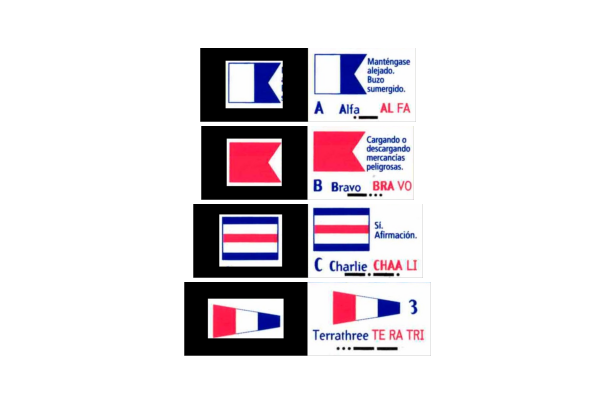

In [ ]:
crop_list = [(d['x'],d['y'],d['width'],d['height'],d['label'] + '.jpg' ) for d in  widget.bboxes]
#crop_list

#Directory for output croppings used for flashcards
!mkdir -p /content/croppings
%cd /content/croppings
%rm *

import cv2

# Load the image
img = cv2.imread('/content/images/codigo-de-señales-maritimas-internacional.jpg')

# Iterate over the list of tuples and create the croppings
for (x, y, w, h, l) in crop_list:
    crop = img[y:y+h, x:x+w]
    cv2.imwrite(l, crop)

!ls

# Preview of flashcards

import os
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import gridspec


def get_image_files(directory):
    image_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_files.append(filename)
    return image_files

def get_image_number(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        return 0

def resize_and_center_image(image, target_size):
    height, width = image.shape[:2]

    # Calculate padding
    h_padding = max(0, (target_size[1] - width) // 2)
    v_padding = max(0, (target_size[0] - height) // 2)

    # Create a black image with the target size
    centered_image = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)

    # Paste the original image into the centered image
    centered_image[v_padding:v_padding + height, h_padding:h_padding + width] = image

    return centered_image

def display_images(images):
    num_images = len(images)

    # Set up the subplot grid
    rows = num_images
    cols = 1
    fig = plt.figure(figsize=(cols * 6 , rows ))
    gs = gridspec.GridSpec(rows, cols, wspace=0.05, hspace=0.05)

    # Display each image in the subplot
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

    plt.show()

#---- This part of the code generates an visual image of the image pairs in order to verify the flashcard contents ------
directory = '.'  # Change this to the directory where your images are located
front_images = sorted([filename for filename in get_image_files(directory) if 'Front' in filename], key=get_image_number)
back_images = sorted([filename for filename in get_image_files(directory) if 'Back' in filename], key=get_image_number)

images = []

for front_img, back_img in zip(front_images, back_images):
    front_path = os.path.join(directory, front_img)
    back_path = os.path.join(directory, back_img)

    # Load images
    front_image = cv2.imread(front_path)
    back_image = cv2.imread(back_path)

    # Resize and center images
    target_size = (max(front_image.shape[0], back_image.shape[0]), max(front_image.shape[1], back_image.shape[1]))
    front_image = resize_and_center_image(front_image, target_size)
    back_image = resize_and_center_image(back_image, target_size)

    # Combine front and back images horizontally
    combined_image = np.concatenate([front_image, back_image], axis=1)

    # Add a small gray border to the combined image
    combined_image = cv2.copyMakeBorder(combined_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=(192, 192, 192))

    images.append(combined_image)

display_images(images)


In [ ]:
#---- This part of the code generates the actual flashcards ------
# https://www.freecodecamp.org/news/supercharged-studying-with-python-anki-chatgpt/
# https://github.com/robxcalib3r/Image2Anki/blob/main/main.py


## Genanki part
import random
import genanki

Anki_model_seed_value = 2
Anki_deck_seed_value = 3
Anki_low_lim = 1000000000
Anki_up_lim = 9999999999
red_color = (0,0,255)
green_color = (0,255,0)
blue_color = (255,0,0)
font = cv2.FONT_HERSHEY_SIMPLEX

# Seed value generation
random.seed(Anki_model_seed_value)
model_val = random.randint(Anki_low_lim, Anki_up_lim)
random.seed(Anki_deck_seed_value)
deck_val = random.randint(Anki_low_lim, Anki_up_lim)

#Create a simple Q&A card template (a card model)
qNa_model = genanki.Model(
    model_val,
    'Q&A',
    fields = [
        {'name': 'Question'},
        {'name': 'Answer'},
    ],
    templates=[
        {
        'name': 'Card 1',
        'qfmt': '{{Question}}',
        'afmt': '{{FrontSide}}<hr id="answer">{{Answer}}',
        },
    ])

#Create an Anki deck
qNa_deck = genanki.Deck(
    deck_val,
    'QnA'
    )

directory = '.'  # Change this to the directory where your images are located
front_images = sorted([filename for filename in get_image_files(directory) if 'Front' in filename], key=get_image_number)
back_images = sorted([filename for filename in get_image_files(directory) if 'Back' in filename], key=get_image_number)

media_files = []

for front_img, back_img in zip(front_images, back_images):
    front_path = os.path.join(directory, front_img)
    back_path = os.path.join(directory, back_img)

    ques_txt = f'<img src="{front_img}" />'
    ans_txt =  f'<img src="{back_img}" />'

    #Create a flashcard (Anki note)
    note = genanki.Note(
        qNa_model,
        fields=
        [
            ques_txt, ans_txt
        ]
    )

    qNa_deck.add_note(note)

    #Prepare to add the actual media files to the deck
    media_files.extend([front_path,back_path])


my_package = genanki.Package(qNa_deck)
my_package.media_files = media_files

my_package.write_to_file('qna.apkg')
print("done saving successfully")

files.download('qna.apkg')

In [ ]:
import yaml
with open('codigo-de-señales-maritimas-internacional.yaml', 'w+') as f:
  yaml.dump(widget.bboxes, f, allow_unicode=True)

files.download('codigo-de-señales-maritimas-internacional.yaml')